<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/Flower-Photos-Classification-AlexNet-VGG16-FT/Flower_dataset_AlexNet_VGG16_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Resizing, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
import pathlib
import numpy as np

# Configuration

In [26]:
class Config:
    IMAGE_SIZE=(224, 224)
    BATCH_SIZE=32
    SEED=123

    # AlexNet (Scratch)
    ALEXNET_LR = 1e-4
    ALEXNET_EPOCHS = 20

    # VGGNet (Fine-Tuning Stages)
    BASE_LR = 1e-3
    FINETUNE_LR = 2e-5      # Adjusted for slightly more aggressive tuning
    BASE_EPOCHS = 10        # Increased for better head initialization
    FINETUNE_EPOCHS = 20    # Increased max epochs for low LR

config = Config()

# Download & Prepare Dataset

In [4]:
DATASET_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    origin=DATASET_URL,
    fname="flower_photos",
    untar=True,
    cache_dir=".",
    cache_subdir=""
)
data_dir = pathlib.Path(data_dir) / 'flower_photos'

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [28]:
CLASS_NAMES = np.array(sorted(
    [item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"]))
NUM_CLASSES = len(CLASS_NAMES)
print(f"Class Names: {CLASS_NAMES}")
print(f"Number of Classes: {NUM_CLASSES}")

Class Names: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
Number of Classes: 5


*Tensorflow Dataset*

In [29]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed=config.SEED,
    subset="training",
    batch_size=config.BATCH_SIZE,
    image_size=config.IMAGE_SIZE
)

validation_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed=config.SEED,
    subset="validation",
    batch_size=config.BATCH_SIZE,
    image_size=config.IMAGE_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


*Check Images Samples*

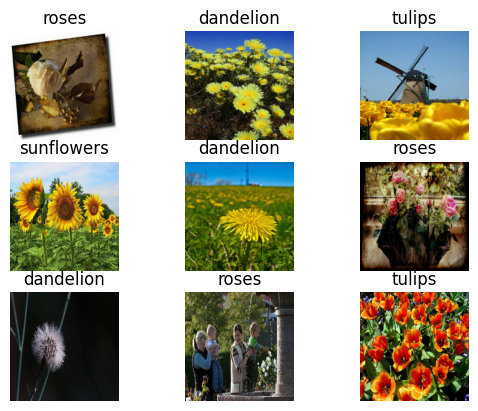

In [30]:
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[label[i]])
        plt.axis("off")

*Number of Samples Per Class*

In [31]:
import collections

# Function to count samples per class in a dataset
def count_samples_per_class(dataset, class_names):
    class_counts = collections.defaultdict(int)
    for _, labels in dataset:
        for label in labels:
            class_counts[class_names[label.numpy()]] += 1
    return class_counts

print("Train Dataset Class Distribution:")
train_class_counts = count_samples_per_class(train_ds, CLASS_NAMES)
for class_name in CLASS_NAMES:
    print(f"  {class_name}: {train_class_counts[class_name]} samples")

print("\nValidation Dataset Class Distribution:")
val_class_counts = count_samples_per_class(validation_ds, CLASS_NAMES)
for class_name in CLASS_NAMES:
    print(f"  {class_name}: {val_class_counts[class_name]} samples")


Train Dataset Class Distribution:
  daisy: 504 samples
  dandelion: 722 samples
  roses: 521 samples
  sunflowers: 547 samples
  tulips: 642 samples

Validation Dataset Class Distribution:
  daisy: 129 samples
  dandelion: 176 samples
  roses: 120 samples
  sunflowers: 152 samples
  tulips: 157 samples


*Preprocess Images for AlexNet*

In [32]:
def preprocess_input(image, label):
    return image / 255.0, tf.one_hot(label, depth=NUM_CLASSES)

# configure dataset
train_ds = train_ds.map(preprocess_input).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(preprocess_input).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Build `AlexNet`

In [33]:
def build_alexnet(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # Conv1
        Conv2D(
            filters=96,
            kernel_size=(11, 11),
            strides=(4, 4),
            activation="relu"
        ),
        MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

        # Conv2
        Conv2D(
            filters=256,
            kernel_size=(5, 5),
            activation="relu",
            padding="same",
        ),
        MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

        # Conv3, Conv4, Conv5
        Conv2D(
            filters=384,
            kernel_size=(3, 3),
            activation="relu",
            padding="same",
        ),
        Conv2D(
            filters=384,
            kernel_size=(3, 3),
            activation="relu",
            padding="same",
        ),
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation="relu",
            padding="same",
        ),
        MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

        # Classification Head (FC)
        Flatten(),
        Dense(1024, activation="relu"),
        Dropout(0.5),
        Dense(1024, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")

    ], name="alexnet_scratch")

    return model


model_alexnet = build_alexnet(config.IMAGE_SIZE + (3,), NUM_CLASSES)

# Compile Model
model_alexnet.compile(
    optimizer=Adam(learning_rate=config.ALEXNET_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_alexnet.summary()

Model: "alexnet_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,356,549 (43.32 MB)

 Trainable params: 11,356,549 (43.32 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [38]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="alexnet_scratch.h5",
        save_best_only=True,
        mode='max',
        monitor="val_accuracy",
    )
]

history_alexnet = model_alexnet.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=config.ALEXNET_EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2494 - loss: 1.5839

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.2499 - loss: 1.5831 - val_accuracy: 0.4414 - val_loss: 1.2264
Epoch 2/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4486 - loss: 1.2340

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.4487 - loss: 1.2339 - val_accuracy: 0.5027 - val_loss: 1.1342
Epoch 3/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5228 - loss: 1.1120

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5230 - loss: 1.1119 - val_accuracy: 0.6131 - val_loss: 0.9843
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5929 - loss: 1.0131 - val_accuracy: 0.6049 - val_loss: 0.9871
Epoch 5/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6099 - loss: 0.9565

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6102 - loss: 0.9558 - val_accuracy: 0.6390 - val_loss: 0.8805
Epoch 6/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6651 - loss: 0.8444

92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.6650 - loss: 0.8445 - val_accuracy: 0.6894 - val_loss: 0.7969
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7026 - loss: 0.7834 - val_accuracy: 0.6580 - val_loss: 0.8363
Epoch 8/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6917 - loss: 0.7660

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6917 - loss: 0.7663 - val_accuracy: 0.7125 - val_loss: 0.7429
Epoch 9/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7132 - loss: 0.7201

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7134 - loss: 0.7202 - val_accuracy: 0.7180 - val_loss: 0.7121
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7636 - loss: 0.6496

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7636 - loss: 0.6497 - val_accuracy: 0.7234 - val_loss: 0.6945
Epoch 11/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7693 - loss: 0.6321

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7691 - loss: 0.6323 - val_accuracy: 0.7289 - val_loss: 0.7102
Epoch 12/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7768 - loss: 0.5887

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7768 - loss: 0.5891 - val_accuracy: 0.7316 - val_loss: 0.6998
Epoch 13/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7908 - loss: 0.5562

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7909 - loss: 0.5562 - val_accuracy: 0.7330 - val_loss: 0.7451
Epoch 14/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8163 - loss: 0.5109

92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8162 - loss: 0.5109 - val_accuracy: 0.7520 - val_loss: 0.6834
Epoch 15/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8217 - loss: 0.4517 - val_accuracy: 0.7466 - val_loss: 0.7132
Epoch 16/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8568 - loss: 0.3991

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8567 - loss: 0.3992 - val_accuracy: 0.7561 - val_loss: 0.7346
Epoch 17/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8680 - loss: 0.3701 - val_accuracy: 0.7234 - val_loss: 0.9642
Epoch 18/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8509 - loss: 0.4019 - val_accuracy: 0.7561 - val_loss: 0.7577
Epoch 19/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8738 - loss: 0.3498 - val_accuracy: 0.7561 - val_loss: 0.8694


# Load `VGG16`

In [39]:
basemodel_vgg = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=config.IMAGE_SIZE + (3,)
)

# Set trainable to false
basemodel_vgg.trainable = False

*Add New Heads*

In [41]:
def new_head(basemodel, num_classes):
    inputs = Input(shape=config.IMAGE_SIZE + (3,))
    x = basemodel(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

## Training `VGG16`'s New Heads

In [42]:
vgg16_model = new_head(basemodel_vgg, NUM_CLASSES)
vgg16_model.summary()

vgg16_model.compile(
    optimizer=Adam(learning_rate=config.BASE_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,909 (57.14 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
history_base = vgg16_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=config.BASE_EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - accuracy: 0.4270 - loss: 1.3700 - val_accuracy: 0.7166 - val_loss: 0.7955
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7349 - loss: 0.7743

92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.7350 - loss: 0.7739 - val_accuracy: 0.7793 - val_loss: 0.6499
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7738 - loss: 0.6597

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.7739 - loss: 0.6595 - val_accuracy: 0.7847 - val_loss: 0.5939
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7955 - loss: 0.5883

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.7955 - loss: 0.5882 - val_accuracy: 0.7970 - val_loss: 0.5439
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8083 - loss: 0.5569

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.8084 - loss: 0.5568 - val_accuracy: 0.8065 - val_loss: 0.5221
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8156 - loss: 0.5262

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.8157 - loss: 0.5260 - val_accuracy: 0.8174 - val_loss: 0.4955
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8249 - loss: 0.5026

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.8250 - loss: 0.5024 - val_accuracy: 0.8215 - val_loss: 0.4814
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.8384 - loss: 0.4660 - val_accuracy: 0.8188 - val_loss: 0.4784
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8468 - loss: 0.4505

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.8468 - loss: 0.4503 - val_accuracy: 0.8283 - val_loss: 0.4702
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8515 - loss: 0.4326

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.8515 - loss: 0.4325 - val_accuracy: 0.8379 - val_loss: 0.4400


## Training `VGG`'s Layers

In [44]:
basemodel_vgg.trainable = True

fine_tune_at = 11
for layer in basemodel_vgg.layers[:fine_tune_at]:
    layer.trainable = False

vgg16_model.compile(
    optimizer=Adam(learning_rate=config.FINETUNE_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

vgg_history = vgg16_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=config.FINETUNE_EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8422 - loss: 0.4557

92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 413ms/step - accuracy: 0.8424 - loss: 0.4550 - val_accuracy: 0.8856 - val_loss: 0.3121
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9279 - loss: 0.2049

92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 395ms/step - accuracy: 0.9280 - loss: 0.2048 - val_accuracy: 0.8869 - val_loss: 0.3333
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 306ms/step - accuracy: 0.9630 - loss: 0.1192 - val_accuracy: 0.8801 - val_loss: 0.3677
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.9808 - loss: 0.0738 - val_accuracy: 0.8515 - val_loss: 0.4952
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 309ms/step - accuracy: 0.9829 - loss: 0.0516 - val_accuracy: 0.8583 - val_loss: 0.5209
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9832 - loss: 0.0597

92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 381ms/step - accuracy: 0.9832 - loss: 0.0596 - val_accuracy: 0.9033 - val_loss: 0.3370


# Evaluation Between Models

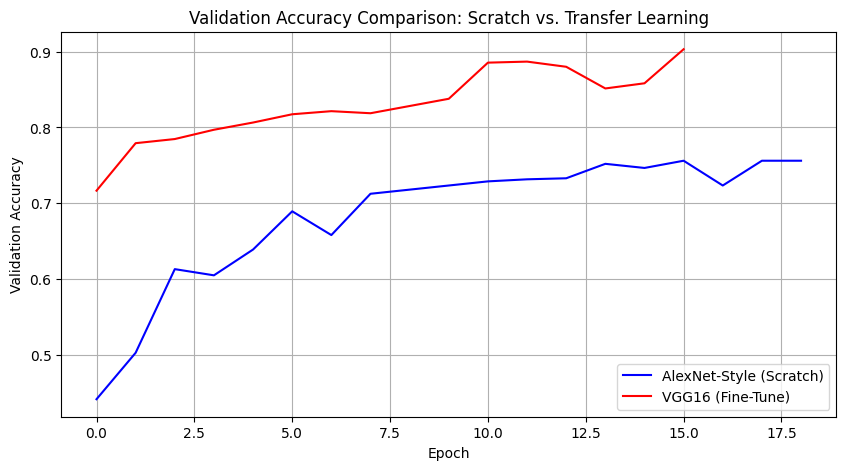


--- Final Performance Summary ---
1. AlexNet-Style (Scratch) Final Val Acc: 0.7561
2. VGG16 (Fine-Tune) Final Val Acc: 0.9033


In [45]:
def plot_comparison_final(history_scratch, history_base, history_ft):

    # 1. Combine VGG history: Base + FineTune
    vgg_acc = history_base.history['accuracy'] + history_ft.history['accuracy']
    vgg_val_acc = history_base.history['val_accuracy'] + history_ft.history['val_accuracy']

    # 2. Get epoch ranges for each model
    epochs_scratch_range = range(len(history_scratch.history['accuracy']))
    epochs_transfer_range = range(len(vgg_val_acc))

    plt.figure(figsize=(10, 5))

    # Accuracy Plot
    plt.plot(epochs_scratch_range, history_scratch.history['val_accuracy'], label='AlexNet-Style (Scratch)', color='blue')
    plt.plot(epochs_transfer_range, vgg_val_acc, label='VGG16 (Fine-Tune)', color='red')
    plt.legend(loc='lower right')
    plt.title('Validation Accuracy Comparison: Scratch vs. Transfer Learning')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    plt.show()

    # Final Accuracy Comparison
    final_alexnet_acc = history_scratch.history['val_accuracy'][-1]
    final_vgg_acc = vgg_val_acc[-1]

    print("\n--- Final Performance Summary ---")
    print(f"1. AlexNet-Style (Scratch) Final Val Acc: {final_alexnet_acc:.4f}")
    print(f"2. VGG16 (Fine-Tune) Final Val Acc: {final_vgg_acc:.4f}")

plot_comparison_final(history_alexnet, history_base, vgg_history)